In [1]:
### Load necessary libraries ###
import glob
import os
import librosa
import librosa.display

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

In [51]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import csv
import io

# Load the model.
model = hub.load('./YAMNET/model')

# Input: 3 seconds of silence as mono 16 kHz waveform samples.
waveform = np.zeros(6 * 16000, dtype=np.float32)
# Run the model, check the output.
_, embeddings, _ = model(sound_clip)
# scores.shape.assert_is_compatible_with([None, 521])
# embeddings.shape.assert_is_compatible_with([None, 1024])
# log_mel_spectrogram.shape.assert_is_compatible_with([None, 64])

# # Find the name of the class with the top score when mean-aggregated across frames.
# def class_names_from_csv(class_map_csv_text):
#   """Returns list of class names corresponding to score vector."""
#   class_map_csv = io.StringIO(class_map_csv_text)
#   class_names = [display_name for (class_index, mid, display_name) in csv.reader(class_map_csv)]
#   class_names = class_names[1:]  # Skip CSV header
#   return class_names
# class_map_path = model.class_map_path().numpy()
# class_names = class_names_from_csv(tf.io.read_file(class_map_path).numpy().decode('utf-8'))
# print(class_names[scores.numpy().mean(axis=0).argmax()])  # Should print 'Silence'.



In [ ]:
# _, embeddings, _ = model(waveform)
import matplotlib.pyplot as plt

fn = "./UrbanSounds8K/audio/augmented/fold1/noise/203356-3-0-2.wav"
# fn = "./UrbanSounds8K/audio/augmented/fold1/7061-6-0-0.wav"
sound_clip,sr = librosa.load(fn, sr=16000)
_, embeddings, _ = model(sound_clip)
f,axs=plt.subplots(figsize=(25,25)) #ROW,COLUMN
axs.imshow(embeddings,interpolation='nearest', aspect='auto')

In [2]:
### Define helper functions ###
# Load the model.
preprocess_model = hub.load('./YAMNET/model')

def extract_features(parent_dir,sub_dirs,file_ext="*.wav"):

    features, labels = [], []

    for fn in glob.glob(os.path.join(parent_dir, sub_dirs, file_ext)):

        # Load data with label
        yamnet_embeddings, segment_labels = [], []
        sound_clip,sr = librosa.load(fn, sr=16000)
        label = int(fn.split('/')[2].split('-')[1])

        _, segment_embeddings, _ = preprocess_model(sound_clip)
        segment_labels = np.tile(label, len(segment_embeddings) )

        # vgg_embeddings = np.asarray(vgg_embeddings).reshape(
        #     len(vgg_embeddings),bands,frames,1)

        # Append if not empty segment
        if len(segment_embeddings) > 0:  
            features.append(segment_embeddings)
            labels.append(segment_labels)
        # print(labels)
        
    return features, labels

In [3]:
# # Pre-process and extract feature from the data
parent_dir = 'UrbanSounds8K/audio/'
save_dir = "UrbanSounds8K/processed_yamnet/"   
# folds = sub_dirs = np.array(['fold1','fold2','fold3','fold4',
#                   'fold5','fold6','fold7','fold8',
#                   'fold9','fold10'])
                  
folds = sub_dirs = np.array(['fold4',
                  'fold5','fold6','fold7','fold8',
                  'fold9','fold10'])

for sub_dir in sub_dirs:
    features, labels = extract_features(parent_dir,sub_dir)
    np.savez("{0}{1}".format(save_dir, sub_dir), 
             features=features, 
             labels=labels)
    print("Completed: ", sub_dir)

C:\ProgramData\Miniconda3\envs\usc39\lib\site-packages\numpy\lib\npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


Completed:  fold4
Completed:  fold5
Completed:  fold6
Completed:  fold7
Completed:  fold8
Completed:  fold9
Completed:  fold10


In [25]:
# Understanding the shape of the data

# data = np.load("D:/Github/aqibsaeed/UrbanSounds8K/processed_vgg/fold2.npz", allow_pickle=True)
data = np.load("D:/Github/aqibsaeed/UrbanSounds8K/processed_yamnet/fold2.npz", allow_pickle=True)
# x_train = data["features"].flatten()[:, np.newaxis]
# y_train = data["labels"].flatten()[:, np.newaxis]

x_train = np.expand_dims(np.concatenate(data["features"], axis=0), axis=1)
y_train = np.expand_dims(np.concatenate(data["labels"], axis=0), axis=1)
print(np.shape(y_train))

# x_train = x_train[np.newaxis,:]
# print(np.shape(x_train))
x_test = data["features"]
y_test = data["labels"]
ind = 102

print("All train sample shape: " + str(np.shape(x_train)))
print("All test sample shape: " + str(np.shape(x_test)))

print("Single train sample shape: " + str(np.shape(x_train[ind])))
print("Single test sample shape: " + str(np.shape(x_test[ind])))

print("Single train label shape: " + str(np.shape(y_train[ind])))
print("Single test label shape: " + str(np.shape(y_test[ind])))

print("Single train label: " + str(y_train[ind]))
print("Single test label: " + str(y_test[ind]))

(6257, 1)
All train sample shape: (6257, 1, 1024)
All test sample shape: (888,)
Single train sample shape: (1, 1024)
Single test sample shape: (8, 1024)
Single train label shape: (1,)
Single test label shape: (8,)
Single train label: [8]
Single test label: [8 8 8 8 8 8 8 8]


In [24]:
x_train = np.expand_dims(np.concatenate(data["features"], axis=0), axis=1)
print(np.concatenate((x_train,x_train), axis=0).shape)

NameError: name 'data' is not defined

In [ ]:
for x, y in zip(x_test, y_test):
    segment_prediction = []
    for segment in x:
        # average predictions over segments of a sound clip
        print(np.shape(segment[np.newaxis,:]))
        segment_prediction.append(model.predict(segment))


    avg_p = np.argmax(np.mean(segment_prediction, axis = 0))
    y_pred.append(avg_p) 
    # pick single label via np.unique for a sound clip
    y_true.append(np.unique(y)[0]) 

In [26]:
### Define FF network architecture following VGG feature extraction ###
def get_network():
    num_classes = 10
    keras.backend.clear_session()
    
    input_shape = (1,1024)
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(128, activation="relu", input_shape = input_shape))
    model.add(keras.layers.Dropout(.2))

    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dropout(.2))

    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dropout(.2))
    
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dense(num_classes, activation="softmax"))

    model.compile(optimizer=keras.optimizers.Adam(1e-4), 
        loss=keras.losses.SparseCategoricalCrossentropy(), 
        metrics=["accuracy"])
        
    return model

model = get_network()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 128)            131200    
_________________________________________________________________
dropout (Dropout)            (None, 1, 128)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 128)            16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 128)            16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1, 128)            1

Epoch 1/50
99/99 [==============================] - 5s 38ms/step - loss: 2.0229 - accuracy: 0.3127 - val_loss: 1.4860 - val_accuracy: 0.6046
Epoch 2/50
99/99 [==============================] - 2s 21ms/step - loss: 1.2041 - accuracy: 0.6111 - val_loss: 0.8916 - val_accuracy: 0.6916
Epoch 3/50
99/99 [==============================] - 2s 20ms/step - loss: 0.9127 - accuracy: 0.6916 - val_loss: 0.7907 - val_accuracy: 0.7306
Epoch 4/50
99/99 [==============================] - 2s 20ms/step - loss: 0.8228 - accuracy: 0.7241 - val_loss: 0.7392 - val_accuracy: 0.7528
Epoch 5/50
99/99 [==============================] - 2s 20ms/step - loss: 0.7731 - accuracy: 0.7436 - val_loss: 0.7062 - val_accuracy: 0.7631
Epoch 6/50
99/99 [==============================] - 2s 20ms/step - loss: 0.7338 - accuracy: 0.7543 - val_loss: 0.6810 - val_accuracy: 0.7692
Epoch 7/50
99/99 [==============================] - 2s 19ms/step - loss: 0.7060 - accuracy: 0.7651 - val_loss: 0.6633 - val_accuracy: 0.7777
Epoch 8/50
99

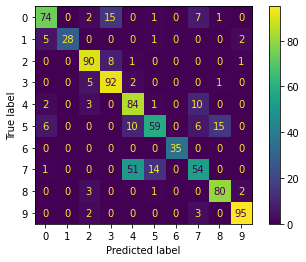

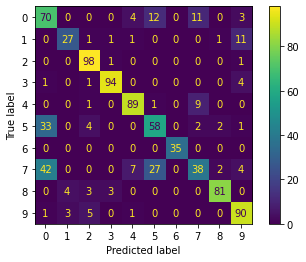

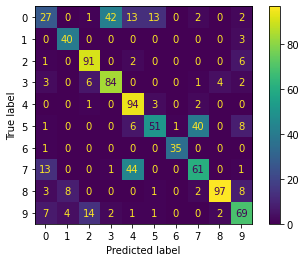

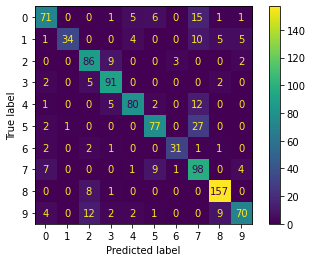

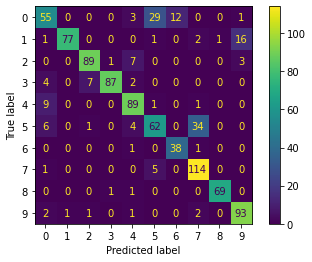

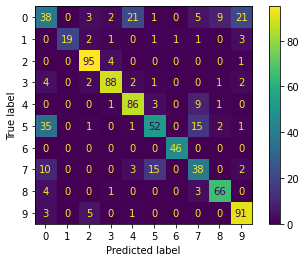

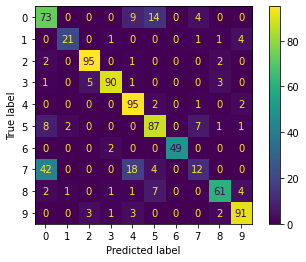

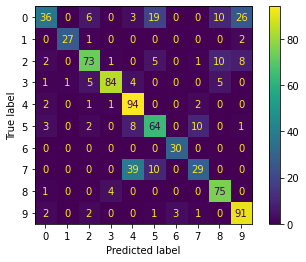

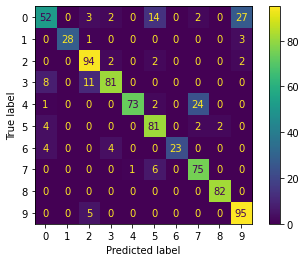

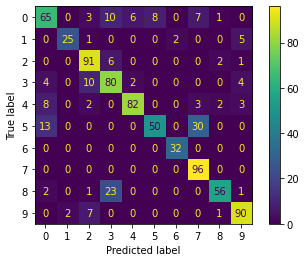

In [29]:
### Load necessary libraries ###
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import datetime

model_types = ["YAMNET_FF"]

for model_type in model_types:

    training_logs_path = os.path.join(model_type, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    conf_mat_path = os.path.join(training_logs_path, "conf_mats")
    os.makedirs(conf_mat_path)
    
    ### Train and evaluate via 10-Folds cross-validation ###
    accuracies = []
    folds = np.array(['fold1','fold2','fold3','fold4',
                    'fold5','fold6','fold7','fold8',
                    'fold9','fold10'])
    load_dir = "UrbanSounds8K/processed_yamnet/"
    kf = KFold(n_splits=10)

    for train_index, test_index in kf.split(folds):
        log_dir = os.path.join(training_logs_path, "logs", "fit", folds[test_index][0])
        models_dir = os.path.join(training_logs_path, "models", folds[test_index][0])

        x_train, y_train = [], []
        for ind in train_index:
            # read features or segments of an audio file
            train_data = np.load("{0}/{1}.npz".format(load_dir,folds[ind]), 
                        allow_pickle=True)
            # for training stack all the segments so that they are treated as an example/instance
            # features = np.concatenate(train_data["features"], axis=0) 
            # labels = np.concatenate(train_data["labels"], axis=0)
            features = np.expand_dims(np.concatenate(train_data["features"], axis=0), axis=1)
            labels = np.expand_dims(np.concatenate(train_data["labels"], axis=0), axis=1)
            
            x_train.append(features)
            y_train.append(labels)

        # stack x,y pairs of all training folds 
        x_train = np.concatenate(x_train, axis = 0).astype(np.float32)
        y_train = np.concatenate(y_train, axis = 0).astype(np.float32)
        
        # shuffle this training data because there is validation split later
        idx = np.random.permutation(len(y_train))
        x_train, y_train = x_train[idx], y_train[idx]
        
        # for testing we will make predictions on each segment and average them to 
        # produce single label for an entire sound clip.
        test_data = np.load("{0}/{1}.npz".format(load_dir,
                    folds[test_index][0]), allow_pickle=True)

        # x_test = np.concatenate(test_data["features"], axis=0)
        # y_test = np.concatenate(test_data["labels"], axis=0)
        
        x_test = test_data["features"]
        y_test = test_data["labels"]
        
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

        model = get_network()
        

        # fit model
        model.fit(x_train, y_train, epochs = 50, batch_size = 512, verbose = 1, validation_split=0.1, 
                    use_multiprocessing=True, workers=8, callbacks=[tensorboard_callback])
        
        # evaluate on test set/fold
        y_true, y_pred = [], []
        for x, y in zip(x_test, y_test):
            
            # average predictions over segments of a sound clip
            segment_prediction = []
            for segment in x:
                segment_prediction.append(model.predict(segment[np.newaxis,:][np.newaxis,:]))
            avg_p = np.argmax(np.mean(segment_prediction, axis = 0))

            # # average predictions over segments of a sound clip
            # avg_p = np.argmax(np.mean(model.predict(x), axis = 0))

            y_pred.append(avg_p) 
            # pick single label via np.unique for a sound clip
            y_true.append(np.unique(y)[0]) 

        accuracies.append(accuracy_score(y_true, y_pred))    
        print("Fold n accuracy: {0}".format(accuracy_score(y_true, y_pred)))

        cm = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
        cm.figure_.savefig(os.path.join(conf_mat_path, "fold_" + str(test_index[0]) + '_acc_' + str(accuracy_score(y_true, y_pred))) + '.png',dpi=1000)

        model.save(os.path.join(models_dir, "fold_" +  str(test_index[0])))

    print("Average 10 Folds Accuracy: {0}".format(np.mean(accuracies)))
    # Average 10 Folds Accuracy: 0.7827486102983903


In [51]:
training_logs_path = os.path.join(model_type, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
conf_mat_path = os.path.join(training_logs_path, "conf_mats")
os.makedirs(conf_mat_path)

log_dir = os.path.join(training_logs_path, "logs", "fit", folds[test_index][0])
print(log_dir)

VGG_FF\20220308-151636\logs\fit\fold1


In [23]:
for i in range(len(test_data["features"])):
    test_data["features"][i] = np.expand_dims(test_data["features"][i], axis=1)
    # print(term.shape)
print(test_data["features"][0].shape)

KeyboardInterrupt: 

In [100]:
model.predict(x_train[0])
model.predict(x_test[0])

array([[1.2715578e-08, 3.4341339e-13, 7.3817233e-04, 9.9926120e-01,
        1.4916118e-08, 2.1915948e-10, 1.2422017e-08, 1.0803437e-11,
        4.1766020e-07, 1.8998691e-07]], dtype=float32)